### import libraries

In [326]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### importing dataset from project files

In [327]:
demo = pd.read_sas('data/nhanes/DEMO_J.XPT')
bmx = pd.read_sas('data/nhanes/BMX_J.XPT')
bpx = pd.read_sas('data/nhanes/BPX_J.XPT')

In [328]:
# Check what you've got
#print(demo.shape)

### STEP 3: Merge DataFrames
##### SEQN — unique participant ID (this is your merge key)
##### RIDAGEYR — age in years
##### RIAGENDR — gender (1=Male, 2=Female)
##### RIDRETH3 — race/ethnicity (detailed)
##### BMXBMI — BMI
##### BPXSY1 — systolic blood pressure (1st reading)
##### BPXDI1 — diastolic blood pressure (1st reading)

### Merging of data using left-merge

In [329]:
# Merge all three on participant ID
#
df = demo.merge(bmx[['SEQN', 'BMXBMI', 'BMXHT', 'BMXWT']], on='SEQN', how='left')
df = df.merge(bpx[['SEQN', 'BPXSY1', 'BPXDI1']], on='SEQN', how='left')

#print(df.shape)  # should be 9254 rows but with more columns now
#print(df.head())

### STEP 4: Pandas Operations(data handling,filtering)

In [330]:
# 1. Filter to adults only
# Filtering to adults (18+) because NHANES includes children and we want health metrics comparable to ICU populations
adults = df[df['RIDAGEYR'] >= 18]
#print(adults.shape, "after filtering to adult")  # should be less than 9254

In [331]:
# 2. Select specific columns
adults[['RIDAGEYR', 'RIAGENDR', 'BMXBMI']]

,RIDAGEYR,RIAGENDR,BMXBMI
2,66.0,2.0,31.7
3,18.0,1.0,21.5
5,66.0,2.0,23.7
6,75.0,2.0,38.9
8,56.0,1.0,21.3
...,...,...,...
9247,64.0,1.0,NaN
9249,70.0,2.0,20.0
9250,42.0,1.0,35.8
9251,41.0,2.0,26.1


In [332]:
# 3. Average BMI by gender
#print(adults.groupby('RIAGENDR')['BMXBMI'].mean())

In [333]:
# 4. Multiple stats at once
#print(adults.groupby('RIAGENDR')['BMXBMI'].agg(['mean', 'median', 'std']))

In [334]:
# 5. Count of each race/ethnicity category
#print(adults['RIDRETH3'].value_counts())

In [335]:
# 6. How many missing values per column
#print(adults.isna().sum())

In [336]:
# 7. Create a complete-cases subset (no missing BMI or BP)
complete = adults.dropna(subset=['BMXBMI', 'BPXSY1'])
#print(complete.shape)

In [337]:
#8. Fill missing blood pressure with median

adults['BPXSY1_filled'] = adults['BPXSY1'].fillna(adults['BPXSY1'].median())

C:\Users\syafi\AppData\Local\Temp\ipykernel_3444\2403744952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adults['BPXSY1_filled'] = adults['BPXSY1'].fillna(adults['BPXSY1'].median())


In [338]:
# 9. Summary stats for all numeric columns
#print(adults.describe())

In [339]:
# 10. Average systolic BP by age group (preview of step 7)

### STEP 5: data cleaning

In [340]:
# See the full missing picture

missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(1)
print("====== MISSING VALUES (%) ======")
print(missing_pct[missing_pct > 0])

====== MISSING VALUES (%) ======
DMQADFC     93.9
RIDAGEMN    93.5
RIDEXPRG    88.0
DMDYRSUS    78.9
DMDEDUC3    75.1
RIDEXAGM    62.9
DMDHSEDZ    48.7
AIALANGA    46.2
DMDMARTL    39.8
DMDEDUC2    39.8
DMQMILIZ    35.1
BPXDI1      31.9
BPXSY1      31.9
MIAINTRP    27.8
MIAPROXY    27.8
MIALANG     27.8
BMXBMI      13.5
BMXHT       13.4
INDFMPIR    13.3
BMXWT        7.3
RIDEXMON     5.9
INDHHIN2     5.3
DMDHREDZ     5.3
INDFMIN2     5.1
FIALANG      5.1
FIAPROXY     5.1
FIAINTRP     5.1
DMDHRMAZ     2.1
dtype: float64


### Step 5b: Handle missing values

##### First, drop columns with more than 50% missing - they're not useful

In [341]:
threshold = 0.50
cols_to_drop = missing_pct[missing_pct > threshold * 100].index.tolist()
print(f"Dropping {len(cols_to_drop)} columns with >50% missing:")
print(cols_to_drop)

adults_clean = adults.drop(columns=cols_to_drop)

# Now drop rows that still have missing values in the remaining columns
# Better approach: select useful columns FIRST, then drop missing values
eda_cols = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH3', 'DMDEDUC2', 'DMDMARTL',
            'INDFMPIR', 'BMXBMI', 'BMXHT', 'BMXWT',
            'BPXSY1', 'BPXDI1']

adults_clean = adults[eda_cols].dropna()

print(f"Before: {len(adults)} rows")
print(f"After: {len(adults_clean)} rows")
print(f"Rows lost: {len(adults) - len(adults_clean)}")
print(f"Missing values: {adults_clean.isna().sum().sum()}")
print("Cleaned DataFrame: ")

Dropping 6 columns with >50% missing:
['DMQADFC', 'RIDAGEMN', 'RIDEXPRG', 'DMDYRSUS', 'DMDEDUC3', 'RIDEXAGM']
Before: 5856 rows
After: 4015 rows
Rows lost: 1841
Missing values: 0
Cleaned DataFrame: 


#### Renaming columns

In [342]:
adults_clean = adults_clean.rename(columns={
    'RIDAGEYR': 'age',
    'RIAGENDR': 'gender',
    'RIDRETH3': 'ethnicity',
    'DMDEDUC2': 'education',
    'DMDMARTL': 'marital_status',
    'INDFMPIR': 'poverty_ratio',
    'BMXBMI': 'bmi',
    'BMXHT': 'height_cm',
    'BMXWT': 'weight_kg',
    'BPXSY1': 'systolic_bp',
    'BPXDI1': 'diastolic_bp'
})

### Actual data handling

In [343]:
# 1. Map gender to readable labels
adults_clean['gender'] = adults_clean['gender'].map({1: 'Male', 2: 'Female'})

# 2. Map ethnicity to readable labels
adults_clean['ethnicity'] = adults_clean['ethnicity'].map({
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    6: 'Non-Hispanic Asian',
    7: 'Other/Multi-Racial'
})

# 3. Map education to readable labels
adults_clean['education'] = adults_clean['education'].map({
    1: 'Less than 9th grade',
    2: '9-11th grade',
    3: 'High school/GED',
    4: 'Some college',
    5: 'College graduate+'
})

# 4. Map marital status to readable labels
adults_clean['marital_status'] = adults_clean['marital_status'].map({
    1: 'Married',
    2: 'Widowed',
    3: 'Divorced',
    4: 'Separated',
    5: 'Never married',
    6: 'Living with partner'
})

# 5. Convert numeric columns to integers
adults_clean['age'] = adults_clean['age'].astype(int)
adults_clean['systolic_bp'] = adults_clean['systolic_bp'].astype(int)
adults_clean['diastolic_bp'] = adults_clean['diastolic_bp'].astype(int)

### Cleaned DataFrame

In [344]:
adults_clean = adults_clean.reset_index(drop=True)
adults_clean.index = adults_clean.index + 1
adults_clean.head(100)

,age,gender,ethnicity,education,marital_status,poverty_ratio,bmi,height_cm,weight_kg,systolic_bp,diastolic_bp
1,75,Female,Non-Hispanic Black,Some college,Widowed,0.41,38.9,151.1,88.8,120,66
2,56,Male,Non-Hispanic Asian,College graduate+,Married,5.00,21.3,170.6,62.1,108,68
3,67,Male,Non-Hispanic White,High school/GED,Divorced,2.65,23.5,178.6,74.9,104,70
4,71,Male,Other/Multi-Racial,High school/GED,Married,1.56,22.5,170.6,65.6,112,60
5,61,Male,Non-Hispanic Asian,College graduate+,Married,5.00,30.7,159.2,77.7,120,72
...,...,...,...,...,...,...,...,...,...,...,...
96,41,Male,Non-Hispanic Asian,College graduate+,Never married,5.00,24.8,165.9,68.2,118,72
97,41,Male,Non-Hispanic Asian,Some college,Married,5.00,34.6,176.6,107.9,110,60
98,34,Male,Non-Hispanic White,High school/GED,Never married,5.00,24.3,176.7,75.8,108,76
99,36,Male,Non-Hispanic White,High school/GED,Living with partner,1.63,30.8,192.9,114.6,122,74


#### Exporting DataFrame into CSV

In [345]:
adults_clean.to_csv('nhanes_clean.csv', index=False)

### Step 6: Visualisations

#### 1. Histogram — BMI distribution
#distribution of BMI across the year 2017-2018
#Highest BMI range is in the 25-30 bin
#steep positive skew 30 onwards

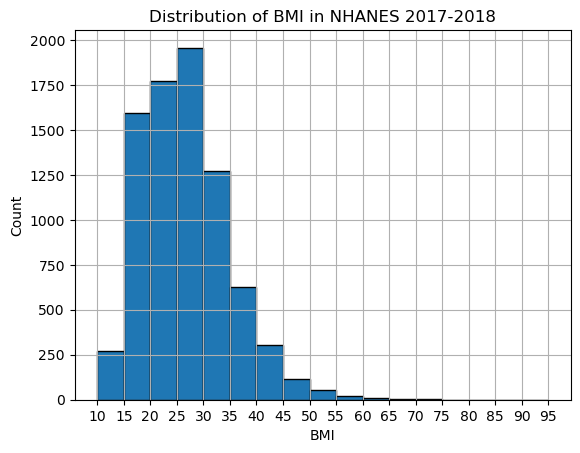

In [346]:
bins = range(10, 100, 5)
df['BMXBMI'].hist(bins=bins, edgecolor='black')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('Distribution of BMI in NHANES 2017-2018')
plt.xticks(bins)
plt.grid(bins)
plt.show()

#### 2. Bar chart — Average BMI by gender
#female have slightly higher mean of BMI

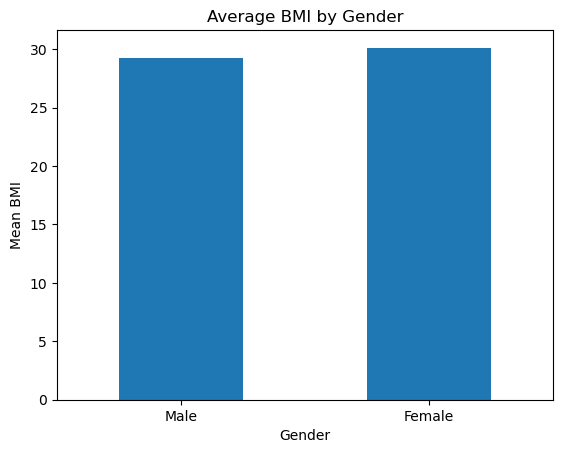

In [347]:
df.groupby(adults['RIAGENDR'])['BMXBMI'].mean().plot(kind='bar')
plt.xticks([0, 1], ['Male', 'Female'], rotation=0)
plt.ylabel('Mean BMI')
plt.xlabel('Gender')
plt.title('Average BMI by Gender')
plt.show()

In [348]:
### 3. Scatter plot — Age vs Systolic BP
#Observation: systolic BP trends upward with age, especially after 50. Expect this to be a strong predictor.

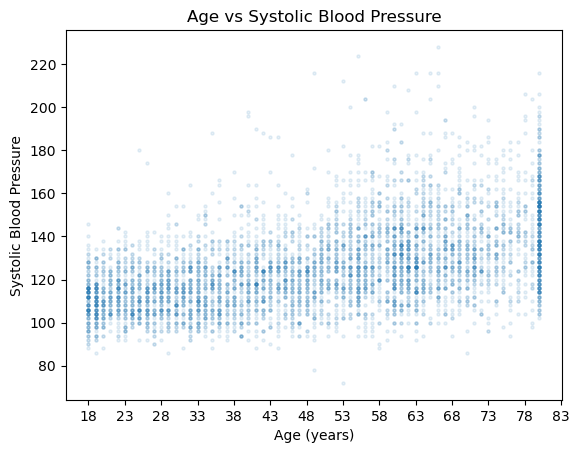

In [349]:
plt.scatter(adults['RIDAGEYR'], adults['BPXSY1'], alpha=0.1, s=5)
plt.xlabel('Age (years)')
plt.ylabel('Systolic Blood Pressure')
plt.title('Age vs Systolic Blood Pressure')
plt.xticks(range(18, 85, 5))
plt.show()

### Correlation Matrix

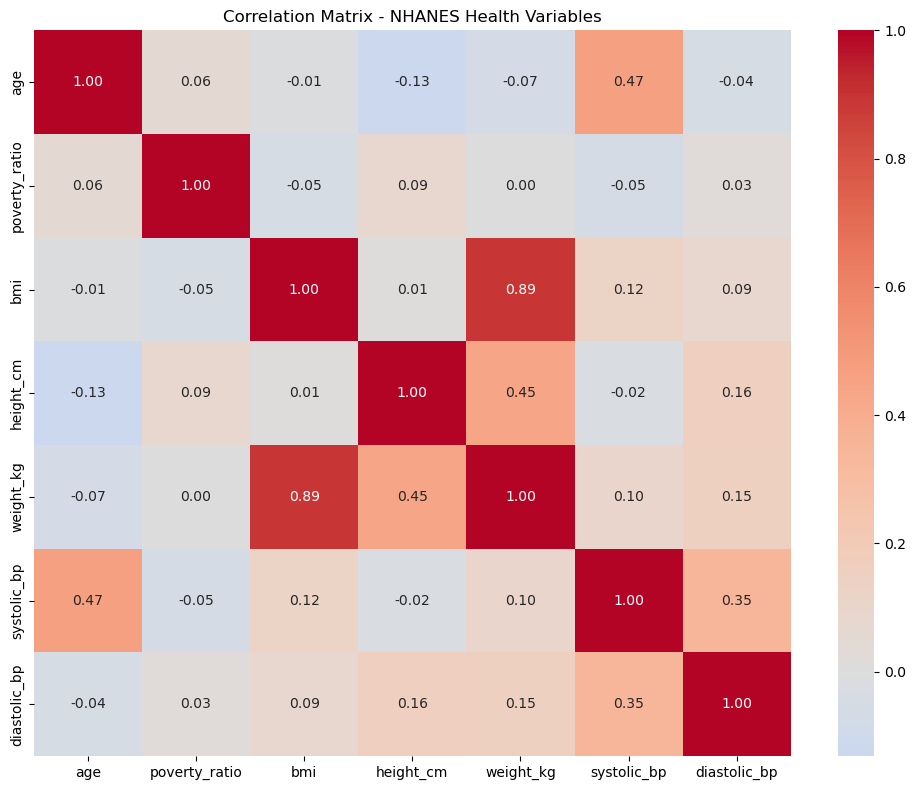

In [350]:
import seaborn as sns

# Correlation matrix (only numeric columns)
corr = adults_clean.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix - NHANES Health Variables')
plt.tight_layout()
plt.show()

#### Derived features

In [358]:
adults_clean['map_pressure'] = adults_clean['diastolic_bp'] + (adults_clean['systolic_bp'] - adults_clean['diastolic_bp']) / 3
adults_clean['pulse_pressure'] = adults_clean['systolic_bp'] - adults_clean['diastolic_bp']
adults_clean['bmi_category'] = pd.cut(adults_clean['bmi'],
    bins=[0, 18.5, 25, 30, 40, 100],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese'])
adults_clean['hypertension'] = ((adults_clean['systolic_bp'] >= 140) | (adults_clean['diastolic_bp'] >= 90)).astype(int)
adults_clean['age_group'] = pd.cut(adults_clean['age'], bins=[18,30,45,60,75,100],
                                    labels=['18-29','30-44','45-59','60-74','75+'])

#### 2. Ethnicity vs Avg Poverty Ratio

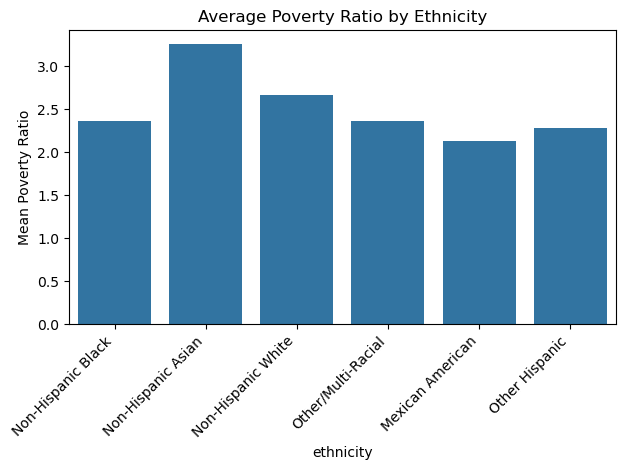

In [352]:
sns.barplot(data=adults_clean, x='ethnicity', y='poverty_ratio', estimator='mean', errorbar=None)
plt.title('Average Poverty Ratio by Ethnicity')
plt.ylabel('Mean Poverty Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 3. Age vs MAP

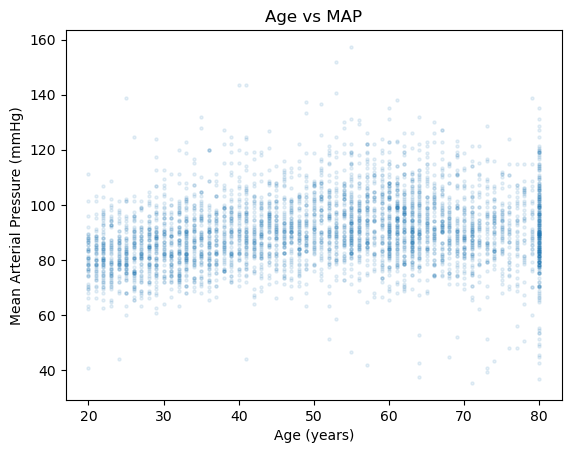

In [353]:
plt.scatter(adults_clean['age'], adults_clean['map_pressure'], alpha=0.1, s=5)
plt.xlabel('Age (years)')
plt.ylabel('Mean Arterial Pressure (mmHg)')
plt.title('Age vs MAP')
plt.show()

#### 4. Ethnicity vs MAP

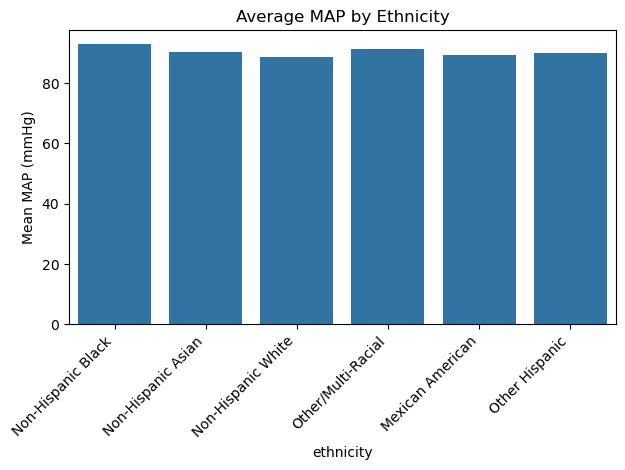

In [354]:
sns.barplot(data=adults_clean, x='ethnicity', y='map_pressure', estimator='mean', errorbar=None)
plt.title('Average MAP by Ethnicity')
plt.ylabel('Mean MAP (mmHg)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 5. Education vs Poverty Ratio

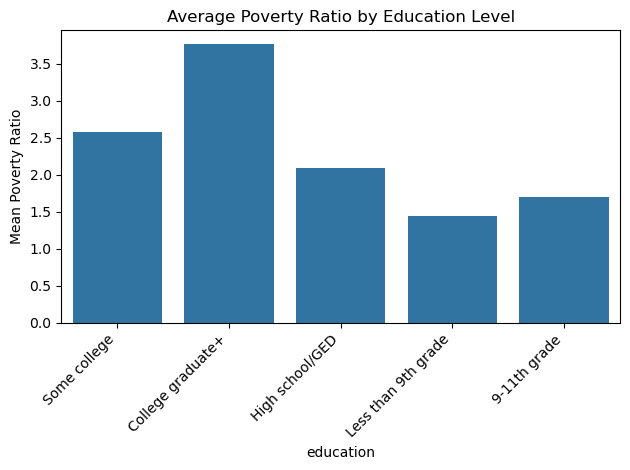

In [355]:
sns.barplot(data=adults_clean, x='education', y='poverty_ratio', estimator='mean', errorbar=None)
plt.title('Average Poverty Ratio by Education Level')
plt.ylabel('Mean Poverty Ratio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### 6. Age vs BMI (scatter)

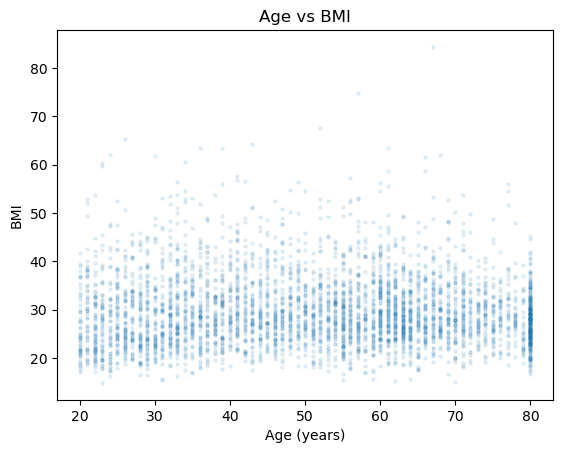

In [356]:
plt.scatter(adults_clean['age'], adults_clean['bmi'], alpha=0.1, s=5)
plt.xlabel('Age (years)')
plt.ylabel('BMI')
plt.title('Age vs BMI')
plt.show()

#### 7. Box plots of BMI by Age Group

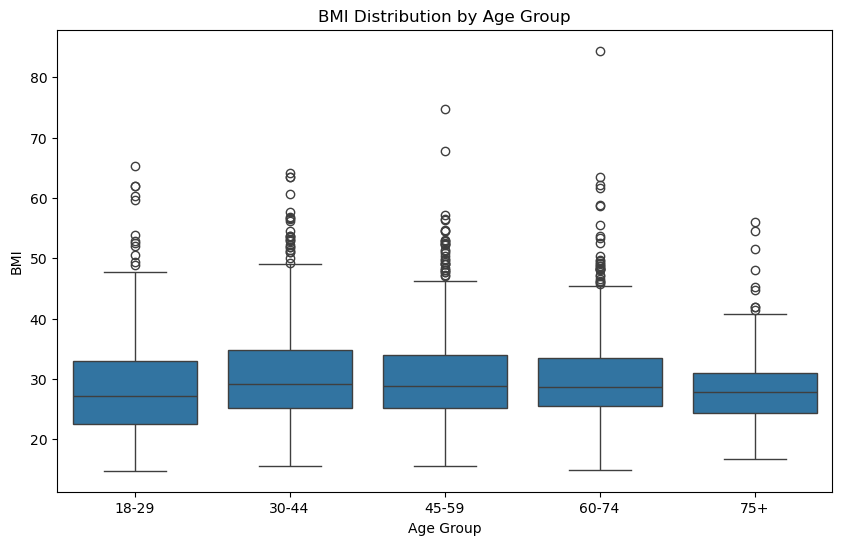

In [359]:
# 7. BMI by Age Group
plt.figure(figsize=(10, 6))
sns.boxplot(data=adults_clean, x='age_group', y='bmi')
plt.title('BMI Distribution by Age Group')
plt.ylabel('BMI')
plt.xlabel('Age Group')
plt.show()

#### 8. BMI Boxplot by Ethnicity

In [ ]:
# 8. BMI by Ethnicity
plt.figure(figsize=(12, 6))
sns.boxplot(data=adults_clean, x='ethnicity', y='bmi')
plt.title('BMI Distribution by Ethnicity')
plt.ylabel('BMI')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

#### 9. Height vs MAP

In [ ]:
plt.scatter(adults_clean['height_cm'], adults_clean['map_pressure'], alpha=0.1, s=5)
plt.xlabel('Height (cm)')
plt.ylabel('Mean Arterial Pressure (mmHg)')
plt.title('Height vs MAP')
plt.show()

#### 10. MAP by Gender

In [ ]:
sns.barplot(data=adults_clean, x='gender', y='map_pressure', estimator='mean', errorbar=None)
plt.title('Average MAP by Gender')
plt.ylabel('Mean MAP (mmHg)')
plt.show()

# EquiScreen — EDA Summary

**Dataset:** NHANES 2017–2018 (CDC) | **Sample:** Adults (≥18) with complete data  
**Variables:** 11 original + 2 derived (MAP, age groups)  
**Author:** Syafiq Khan | **Date:** February 2026

---

## Dataset Overview

The cleaned dataset contains 11 variables across two categories:

**Demographic:** age, gender, ethnicity (6 groups), education (5 levels), marital status, poverty ratio (family income-to-poverty ratio)

**Clinical:** BMI, height (cm), weight (kg), systolic blood pressure, diastolic blood pressure

**Derived features created during EDA:** Mean Arterial Pressure (MAP = diastolic + (systolic − diastolic) / 3) and age group bins (18–29, 30–44, 45–59, 60–74, 75+).

---

## Visualisations Produced (Tableau)

1. **Gender vs Avg BMI** — bar chart comparing average BMI between males and females
2. **Ethnicity vs Avg Poverty Ratio** — bar chart showing socioeconomic differences across ethnic groups
3. **Age vs MAP** — scatter plot showing how mean arterial pressure trends with age
4. **Ethnicity vs MAP** — bar chart comparing average MAP across ethnic groups
5. **Education vs Poverty Ratio** — bar chart showing the link between education level and income
6. **Age vs BMI** — scatter plot of BMI across the age range
7. **Box plots of BMI by Age Group** — distribution of BMI across five age brackets with outlier visibility
8. **BMI Boxplot by Ethnicity** — distribution of BMI across six ethnic groups
9. **Height vs MAP** — scatter plot examining the relationship between height and blood pressure
10. **MAP by Gender** — bar chart comparing average MAP between males and females

---

## Key Findings

### 1. Age is the strongest predictor of blood pressure

The correlation matrix showed a 0.47 correlation between age and systolic BP — the strongest relationship among all variable pairs (excluding the trivially related BMI–weight pair at 0.89). The Age vs MAP scatter plot confirms this: MAP increases steadily with age, reflecting arterial stiffening and increased cardiovascular strain in older adults. This matters for prediction because age will likely dominate any blood-pressure-related model, and for fairness because age groups will have inherently different baseline risk levels.

### 2. BMI and weight are near-redundant

BMI and weight correlate at 0.89, which is expected since BMI is derived from weight and height. Including both in a model would introduce multicollinearity — one should be dropped. BMI is the better choice to retain because it adjusts for height, making it more clinically meaningful. The BMI boxplots by age group show a right-skewed distribution across all age brackets, with median BMI in the overweight range (27–29) and significant outliers extending above 60. The 75+ group has a notably tighter distribution, consistent with survivorship bias — individuals with extreme obesity are less likely to reach old age.

### 3. Demographic differences exist across health indicators

The ethnicity-level plots reveal meaningful variation in both BMI distributions and MAP averages across ethnic groups. The poverty ratio also differs substantially by ethnicity and education level, confirming that socioeconomic status is unevenly distributed across demographic groups. These distributional differences are the foundation of potential model bias: if health indicators differ systematically by demographics, a model trained on aggregate data may perform unequally across subgroups. This is exactly what the EquiScreen fairness audit is designed to detect.

---

## Correlation Matrix Summary

| Pair | Correlation | Interpretation |
|------|-------------|----------------|
| BMI ↔ Weight | 0.89 | Near-redundant — drop one (keep BMI) |
| Age ↔ Systolic BP | 0.47 | Strongest clinically meaningful relationship |
| Height ↔ Weight | 0.45 | Expected anatomical relationship |
| Systolic ↔ Diastolic BP | 0.35 | Moderate — both capture blood pressure but carry independent info |
| Poverty ratio ↔ all clinical vars | < 0.10 | Socioeconomic status has weak direct correlation with clinical measures, but its effect is indirect (through access to care, chronic disease management) |

Most feature pairs show low correlation (< 0.2), which is good for modelling — it means features carry independent information with minimal redundancy.

---

## Derived Features & Clinical Rationale

**Mean Arterial Pressure (MAP):** Computed as diastolic + (systolic − diastolic) / 3. MAP reflects organ perfusion pressure and is a standard ICU vital sign. A MAP below 65 mmHg indicates inadequate organ perfusion and is associated with significantly higher mortality risk. In this community dataset, few individuals fall below this threshold, but the variable will be valuable as a predictor of hypertension risk.

**BMI Categories (for Week 4):** Underweight (<18.5), Normal (18.5–25), Overweight (25–30), Obese (30–40), Severely Obese (40+). The non-linear relationship between BMI and health outcomes (the "obesity paradox" — where underweight and severely obese patients fare worst) means categorical BMI may outperform raw BMI in prediction models.

**Hypertension Flag (for Week 4):** Binary target variable — systolic ≥ 140 OR diastolic ≥ 90. This will serve as the prediction target for the first logistic regression model, since NHANES does not contain ICU mortality data.

---

## Implications for Modelling (Week 4)

The prediction task will be **hypertension classification** using age, gender, ethnicity, education, poverty ratio, BMI, height, and MAP as features. Weight will be excluded due to redundancy with BMI. The EDA suggests age and MAP will be the strongest predictors, while demographic variables (ethnicity, education, poverty ratio) may contribute indirectly.

For the **fairness audit**, the key demographic subgroups will be ethnicity and gender. The distributional differences observed in this EDA — particularly in BMI and poverty ratio across ethnic groups — suggest the model may perform unevenly across demographics, making subgroup performance analysis essential.

---

## What's Next

- **Week 4:** Build logistic regression model to predict hypertension from NHANES features. Evaluate with accuracy, precision, recall, F1, and AUC-ROC. Begin subgroup performance analysis.
- **Feature engineering:** Add pulse pressure (systolic − diastolic) and hypertension flag to the dataset before modelling.